# Plot sea ice volume tendency components

Plot the thermodynamic and dynamic volume tendency components. Both are calculated online.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cmocean as cmo
import matplotlib.pyplot as plt
import subprocess

import matplotlib.gridspec as gridspec

User inputs

In [2]:
#model info
diri      = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/RAW/'
cntr_expt = 'metroms_CONTROL' 
pert_expt = 'metroms_4SSFLUX'
varname   = ['dvidtt','dvidtd']  #variable names

#time domain for each experimnt
yrst = 2002 ; mst = 2
yren = 2011 ; men = 11 

#spatial domain (self-explanatory)
latmax = -50.
lonmin = 140.
lonmax = 300. 

#output file destination
diro = ''

In [3]:
path_to_data = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/POST_PROCESS/'

Note on raw data:

The output is saved as 5-day averages with the date of the next day (i.e. 10-14 Mar are saved in 15 Mar). The seasonal climatalogy is based on the month of the output data. While this is not accurate in terms of the name I give a season, it is consistent between years and simulations. 

Import previously loaded data

In [4]:
cntr = xr.open_dataset(path_to_data + 'dvdt_CONTROL_2002_2011_full.nc')
pert = xr.open_dataset(path_to_data + 'dvdt_4SSFLUX_2002_2011_full.nc')
pert_2SSFLUX = xr.open_dataset(path_to_data + 'dvdt_2SSFLUX_2002_2011_full.nc')

Plotting information

In [5]:
# Spherical coordinates
deg2rad = np.pi/180.0

# CICE
x_cice = -(cntr.TLAT+90)*np.cos(cntr.TLON*deg2rad+np.pi/2)
y_cice =  (cntr.TLAT+90)*np.sin(cntr.TLON*deg2rad+np.pi/2)

In [6]:
# Load roms data for plotting
roms = xr.open_dataset('/g/data/gh9/wgh581/ROMS_Output/metroms_files/' + 'RAW/metroms_CONTROL/' + 'ocean_his_0042.nc')
lat_roms = roms.lat_rho[:-15,:-1]#.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)[1:,:]
lon_roms = roms.lon_rho[:-15,:-1]#.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)[1:,:]
zice     = roms.zice[:-15,:-1]#.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)[1:,:]
h        = roms.h[:-15,:-1]#.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)[1:,:]
mask     = roms.mask_rho[:-15,:-1]#.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)[1:,:]

In [7]:
# Masking
h     = np.ma.masked_where(mask==0, h)
zice  = np.ma.masked_where(mask==0, zice)
zice  = np.ma.masked_where(zice==0, zice)
lat_r = np.ma.masked_where(mask==1, lat_roms)

In [8]:
# ROMS
x_roms = -(lat_roms+90)*np.cos(lon_roms*deg2rad+np.pi/2)
y_roms =  (lat_roms+90)*np.sin(lon_roms*deg2rad+np.pi/2)

In [9]:
# Center of missing circle (ROMS)
lat_c   = -83
lon_c   = 50
# Radius of missing circle (play around with this until it works)
radius  = 10.1
# Find center in spherical coordinates
x_c_metroms = -(lat_c+90)*np.cos(lon_c*deg2rad+np.pi/2)
y_c_metroms =  (lat_c+90)*np.sin(lon_c*deg2rad+np.pi/2)
# Build a regular x-y grid and select the missing circle
lat_max = -63+90
x_reg, y_reg = np.meshgrid(np.linspace(-lat_max, lat_max, num=1000), np.linspace(-lat_max, lat_max, num=1000))
land_circle  = np.zeros(np.shape(x_reg))
land_circle_metroms = np.ma.masked_where(np.sqrt((x_reg-x_c_metroms)**2 + (y_reg-y_c_metroms)**2) > radius, land_circle)

In [10]:
# Region range
xlim_min = -25
xlim_max = 15
ylim_min = -30
ylim_max = 7

In [100]:
# # Make sure the coordinates are exactly the same
# x_cice.TLON.values = x_roms.lon_rho.values
# x_cice.TLAT.values = x_roms.lat_rho.values

Seasonal climatology (full time period)

In [11]:
pert_t_seasonal = pert.dvidtt.groupby('time.season').mean('time')
cntr_t_seasonal = cntr.dvidtt.groupby('time.season').mean('time')

pert_d_seasonal = pert.dvidtd.groupby('time.season').mean('time')
cntr_d_seasonal = cntr.dvidtd.groupby('time.season').mean('time')

pert_2SSFLUX_t_seasonal = pert_2SSFLUX.dvidtt.groupby('time.season').mean('time')
pert_2SSFLUX_d_seasonal = pert_2SSFLUX.dvidtd.groupby('time.season').mean('time')

Mask for sea ice area

In [12]:
# Load aice info for masking and adding sea ice extent line to plot
path = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/'
cice_CNTR = 'POST_PROCESS/cice_climatology_CONTROL_2008_2011.nc'
cice_PERT = 'POST_PROCESS/cice_climatology_4SSFLUX_2008_2011.nc'
cice_PERT_2SSFLUX = 'POST_PROCESS/cice_climatology_2SSFLUX_2008_2011.nc'
cice_path = [path + cice_CNTR, path + cice_PERT, path + cice_PERT_2SSFLUX]

aice_extmin = 0.15
# aice_cntr = xr.open_dataset(cice_path[0]).aice[:,:-15,:-1]
# aice_pert = xr.open_dataset(cice_path[1]).aice[:,:-15,:-1]
tmp_cntr  = xr.open_dataset(cice_path[0])
aice_cntr = tmp_cntr.aice.where((tmp_cntr.TLAT <= latmax) & (tmp_cntr.TLON >= lonmin) & (tmp_cntr.TLON <= lonmax), drop=True)
tmp_pert  = xr.open_dataset(cice_path[1])
aice_pert = tmp_cntr.aice.where((tmp_pert.TLAT <= latmax) & (tmp_pert.TLON >= lonmin) & (tmp_pert.TLON <= lonmax), drop=True)
tmp_pert_2SSFLUX  = xr.open_dataset(cice_path[2])
aice_pert_2SSFLUX = tmp_cntr.aice.where((tmp_pert_2SSFLUX.TLAT <= latmax) & (tmp_pert_2SSFLUX.TLON >= lonmin) & (tmp_pert_2SSFLUX.TLON <= lonmax), drop=True)

In [13]:
# Rename time variable and overwrite with values from dvdt
aice_cntr = aice_cntr.rename({'time':'season'})
aice_cntr['season'] = cntr_d_seasonal.season

aice_pert = aice_pert.rename({'time':'season'})
aice_pert['season'] = pert_d_seasonal.season

aice_pert_2SSFLUX = aice_pert_2SSFLUX.rename({'time':'season'})
aice_pert_2SSFLUX['season'] = pert_2SSFLUX_d_seasonal.season

In [14]:
cntr_t_seasonal = cntr_t_seasonal.where(aice_cntr > aice_extmin, np.nan)
pert_t_seasonal = pert_t_seasonal.where(aice_pert > aice_extmin, np.nan)

cntr_d_seasonal = cntr_d_seasonal.where(aice_cntr > aice_extmin, np.nan)
pert_d_seasonal = pert_d_seasonal.where(aice_pert > aice_extmin, np.nan)

pert_2SSFLUX_t_seasonal = pert_2SSFLUX_t_seasonal.where(aice_pert_2SSFLUX > aice_extmin, np.nan)
pert_2SSFLUX_d_seasonal = pert_2SSFLUX_d_seasonal.where(aice_pert_2SSFLUX > aice_extmin, np.nan)

Calculate anomalies

In [19]:
# PERT (4SSFLUX) - CNTR
diff_t_seasonal = pert_t_seasonal - cntr_t_seasonal
diff_d_seasonal = pert_d_seasonal - cntr_d_seasonal
diff_total_seasonal = (diff_t_seasonal + diff_d_seasonal)

# PERT (2SSFLUX) - CNTR
diff_2SSFLUX_t_seasonal = pert_2SSFLUX_t_seasonal - cntr_t_seasonal
diff_2SSFLUX_d_seasonal = pert_2SSFLUX_d_seasonal - cntr_d_seasonal
diff_2SSFLUX_total_seasonal = (diff_2SSFLUX_t_seasonal + diff_2SSFLUX_d_seasonal)

### Full time period

Seasonal climatology

In [16]:
season = ['DJF', 'MAM', 'JJA', 'SON']
ft_size = 14
my_dpi  = 150

# Colorbar
from palettable.scientific.diverging import Vik_19_r
from palettable.colorbrewer.diverging import PRGn_5_r

panel_name = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']#, 'm)', 'n)', 'o)', 'p)']

fig_path = '/g/data/gh9/wgh581/Python_code/plot_code/metroms_code/SeaIce_Story/'

In [17]:
def plot_region():
    plt.tick_params(labelleft=False, labelbottom=False)
    plt.contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    plt.contourf(x_roms, y_roms, lat_r, colors='0.5')
    plt.contourf(x_roms, y_roms, zice*1, colors='k')
    plt.contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    plt.contour(x_cice, y_cice, aice_cntr[ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    plt.tick_params(axis='both', which='both', length=0)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)

4SSFLUX

/jobfs/83048859.gadi-pbs/ipykernel_3467091/614899658.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_total_seasonal[ii]*90*1e-2, vmin=-0.5, vmax=0.5, cmap=Vik_19_r.mpl_colormap)
/jobfs/83048859.gadi-pbs/ipykernel_3467091/614899658.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_t_seasonal[ii]*90*1e-2, vmin=-0.5, vmax=0.5, cmap=Vik_19_r.mpl_colormap)
/jobfs/83048859.gadi-pbs/ipykernel_3467091/614899658.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, bu

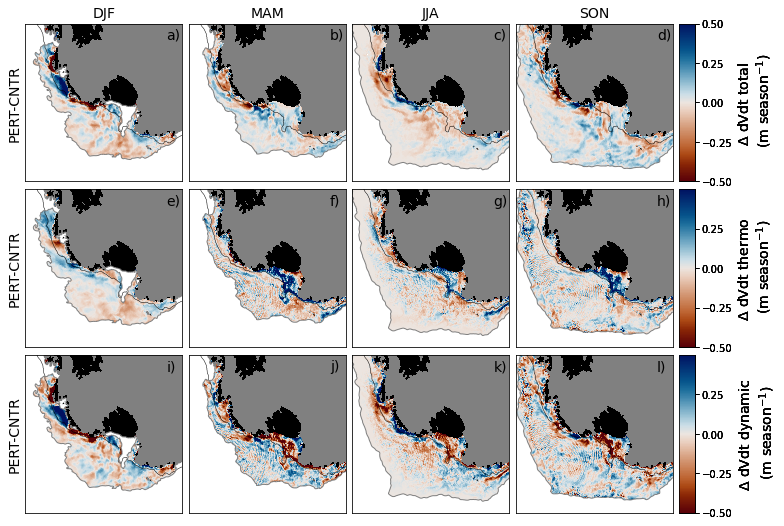

In [19]:
fig = plt.figure(figsize=(12,9))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)

for ii in range(4):
    
    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_total_seasonal[ii]*90*1e-2, vmin=-0.5, vmax=0.5, cmap=Vik_19_r.mpl_colormap)
    plt.title(season[ii], fontsize=ft_size)
    ax.text(0.9, 0.9, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('PERT-CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.5, 0.75, 0.25))
    cbar.set_label('$\Delta$ dVdt total \n (m season$^{-1}$)', fontsize=ft_size)

    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_t_seasonal[ii]*90*1e-2, vmin=-0.5, vmax=0.5, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('PERT-CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.5, 0.5, 0.25))
    cbar.set_label('$\Delta$ dVdt thermo \n (m season$^{-1}$)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs2[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_d_seasonal[ii]*90*1e-2, vmin=-0.5, vmax=0.5, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+8], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('PERT-CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs2[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.5, 0.5, 0.25))
    cbar.set_label('$\Delta$ dVdt dynamic \n (m season$^{-1}$)', fontsize=ft_size)
    
save_fig = 0
if save_fig == 1:
    plt.savefig(fig_path + 'Figure3.png', dpi=my_dpi, bbox_inches='tight', facecolor='white')

/jobfs/67698553.gadi-pbs/ipykernel_536388/3848384304.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, (cntr_t_seasonal+cntr_d_seasonal)[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
/jobfs/67698553.gadi-pbs/ipykernel_536388/3848384304.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, cntr_t_seasonal[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
/jobfs/67698553.gadi-pbs/ipykernel_536388/3848384304.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell cente

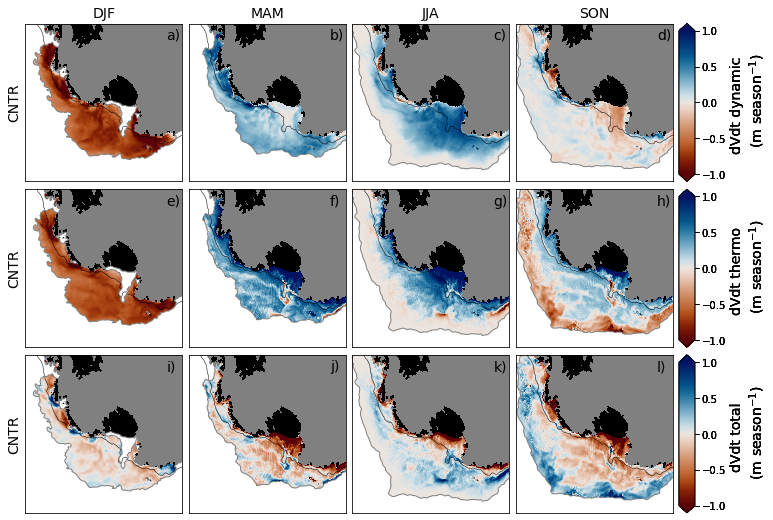

In [26]:
fig = plt.figure(figsize=(12,9))

gs = gridspec.GridSpec(3, 1, height_ratios=[1,1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)

for ii in range(4):
    
    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, (cntr_t_seasonal+cntr_d_seasonal)[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
    plt.title(season[ii], fontsize=ft_size)
    ax.text(0.9, 0.9, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs2[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-1, 1.25, 0.5), extend='both')
    cbar.set_label('dVdt total \n (m season$^{-1}$)', fontsize=ft_size)

    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, cntr_t_seasonal[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-1, 1.25, 0.5), extend='both')
    cbar.set_label('dVdt thermo \n (m season$^{-1}$)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs2[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, cntr_d_seasonal[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+8], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-1, 1.25, 0.5), extend='both')
    cbar.set_label('dVdt dynamic \n (m season$^{-1}$)', fontsize=ft_size)
    
save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'FigureS1_long.png', dpi=my_dpi, bbox_inches='tight', facecolor='white')

/jobfs/67698553.gadi-pbs/ipykernel_536388/1672948320.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, cntr_t_seasonal[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
/jobfs/67698553.gadi-pbs/ipykernel_536388/1672948320.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, cntr_d_seasonal[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)


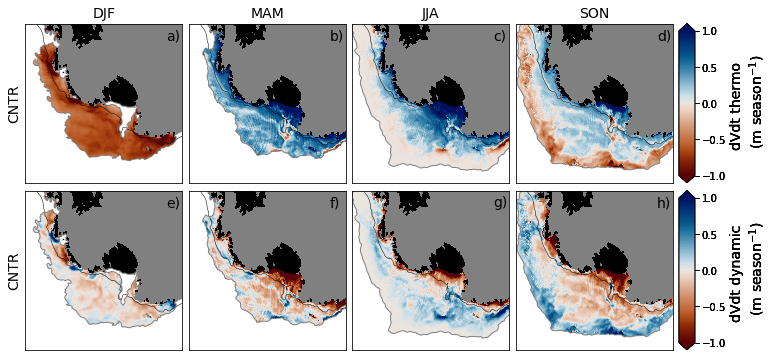

In [28]:
fig = plt.figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for ii in range(4):

    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, cntr_t_seasonal[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
    plt.title(season[ii], fontsize=ft_size)
    ax.text(0.9, 0.9, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-1, 1.25, 0.5), extend='both')
    cbar.set_label('dVdt thermo \n (m season$^{-1}$)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, cntr_d_seasonal[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-1, 1.25, 0.5), extend='both')
    cbar.set_label('dVdt dynamic \n (m season$^{-1}$)', fontsize=ft_size)
    
save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'FigureS1.png', dpi=my_dpi, bbox_inches='tight', facecolor='white')

2SSFLUX

/jobfs/83113665.gadi-pbs/ipykernel_3639670/3867187976.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_2SSFLUX_total_seasonal[ii]*90*1e-2, vmin=-0.5, vmax=0.5, cmap=Vik_19_r.mpl_colormap)
/jobfs/83113665.gadi-pbs/ipykernel_3639670/3867187976.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_2SSFLUX_t_seasonal[ii]*90*1e-2, vmin=-0.5, vmax=0.5, cmap=Vik_19_r.mpl_colormap)
/jobfs/83113665.gadi-pbs/ipykernel_3639670/3867187976.py:35: UserWarning: The input coordinates to pcolormesh are interpreted 

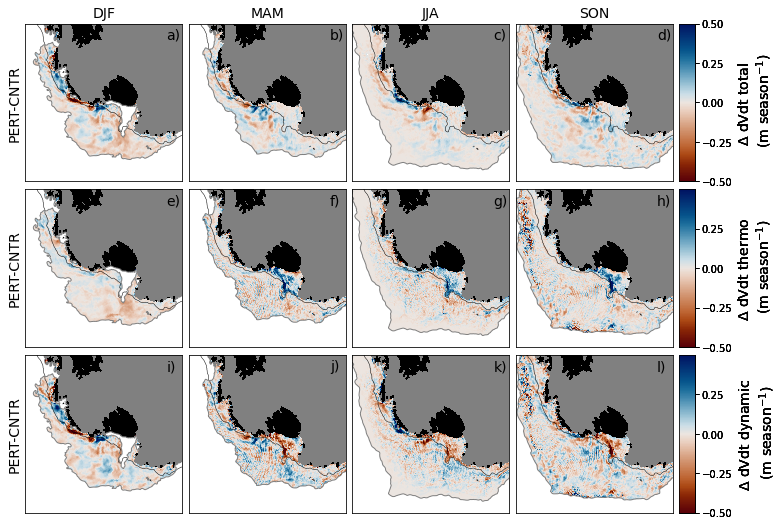

In [21]:
fig = plt.figure(figsize=(12,9))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)

for ii in range(4):
    
    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_2SSFLUX_total_seasonal[ii]*90*1e-2, vmin=-0.5, vmax=0.5, cmap=Vik_19_r.mpl_colormap)
    plt.title(season[ii], fontsize=ft_size)
    ax.text(0.9, 0.9, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('PERT-CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.5, 0.75, 0.25))
    cbar.set_label('$\Delta$ dVdt total \n (m season$^{-1}$)', fontsize=ft_size)

    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_2SSFLUX_t_seasonal[ii]*90*1e-2, vmin=-0.5, vmax=0.5, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('PERT-CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.5, 0.5, 0.25))
    cbar.set_label('$\Delta$ dVdt thermo \n (m season$^{-1}$)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs2[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_2SSFLUX_d_seasonal[ii]*90*1e-2, vmin=-0.5, vmax=0.5, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+8], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('PERT-CNTR', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs2[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.5, 0.5, 0.25))
    cbar.set_label('$\Delta$ dVdt dynamic \n (m season$^{-1}$)', fontsize=ft_size)
    
save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'Figure3_2SSFLUX.png', dpi=my_dpi, bbox_inches='tight', facecolor='white')

Annual average

In [30]:
# Anomaly between perturbation and control simulation
diff_t = pert.dvidtt.mean('time') - cntr.dvidtt.mean('time')
diff_d = pert.dvidtd.mean('time') - cntr.dvidtd.mean('time')

In [33]:
# Total volume tendency (dynamic + thermodynamic)
diff_total = (diff_t + diff_d)
# cm/day -> cm/year
diff_total.values = diff_total.values * 365.

/jobfs/67342504.gadi-pbs/ipykernel_63971/3205406314.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_cice, y_cice, tmp, vmin=-20, vmax=20, cmap=cmo.cm.balance)
/jobfs/67342504.gadi-pbs/ipykernel_63971/3205406314.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_cice, y_cice, cntr.dvidtt.mean('time'), vmin=-1, vmax=1, cmap=cmo.cm.balance)
/jobfs/67342504.gadi-pbs/ipykernel_63971/3205406314.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead t

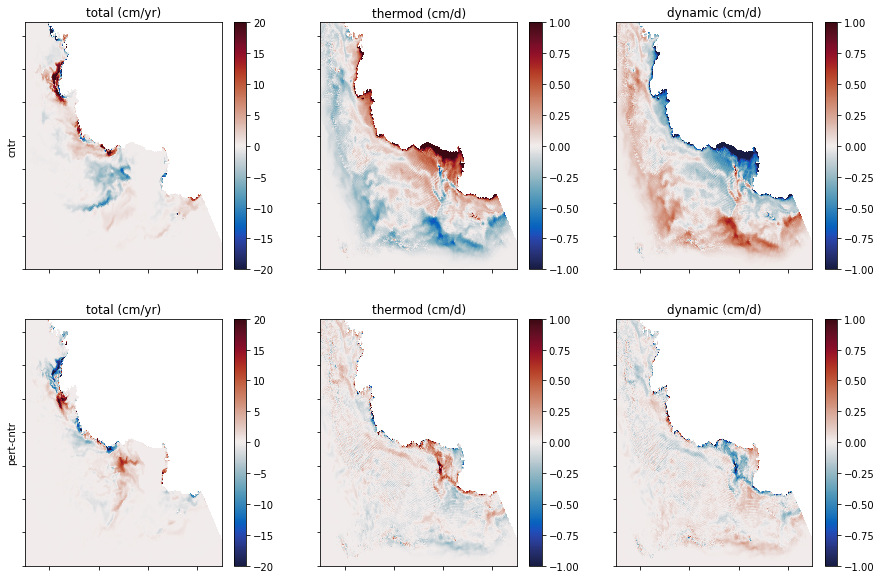

In [87]:
fig = plt.figure(figsize=(15,10))

plt.subplot(231)
tmp = cntr.dvidtt.mean('time')+cntr.dvidtd.mean('time')
tmp.values = tmp.values * 365
plt.pcolormesh(x_cice, y_cice, tmp, vmin=-20, vmax=20, cmap=cmo.cm.balance)
plt.title('total (cm/yr)')
plt.colorbar()
plt.ylabel('cntr')
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False)

plt.subplot(232)
plt.pcolormesh(x_cice, y_cice, cntr.dvidtt.mean('time'), vmin=-1, vmax=1, cmap=cmo.cm.balance)
plt.title('thermod (cm/d)')
plt.colorbar()
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False)

plt.subplot(233)
plt.pcolormesh(x_cice, y_cice, cntr.dvidtd.mean('time'), vmin=-1, vmax=1, cmap=cmo.cm.balance)
plt.title('dynamic (cm/d)')
plt.colorbar()
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False)

plt.subplot(234)
plt.pcolormesh(x_cice, y_cice, diff_total, vmin=-20, vmax=20, cmap=cmo.cm.balance)
plt.title('total (cm/yr)')
plt.colorbar()
plt.ylabel('pert-cntr')
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False)

plt.subplot(235)
plt.pcolormesh(x_cice, y_cice, diff_t, vmin=-1, vmax=1, cmap=cmo.cm.balance)
plt.title('thermod (cm/d)')
plt.colorbar()
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False)

plt.subplot(236)
plt.pcolormesh(x_cice, y_cice, diff_d, vmin=-1, vmax=1, cmap=cmo.cm.balance)
plt.title('dynamic (cm/d)')
plt.colorbar()
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.tick_params(labelleft=False, labelbottom=False);

### First three years

In [18]:
cntr_3yr = cntr.sel(time=slice('2002-03-01','2005-02-28')).groupby('time.season').mean('time')
pert_3yr = pert.sel(time=slice('2002-03-01','2005-02-28')).groupby('time.season').mean('time')

In [19]:
diff_t_seasonal_3yr = pert_3yr.dvidtt - cntr_3yr.dvidtt
diff_d_seasonal_3yr = pert_3yr.dvidtd - cntr_3yr.dvidtd
diff_total_seasonal_3yr = (diff_t_seasonal_3yr + diff_d_seasonal_3yr)

/jobfs/67419030.gadi-pbs/ipykernel_73853/1021338011.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_total_seasonal_3yr[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance)
/jobfs/67419030.gadi-pbs/ipykernel_73853/1021338011.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_t_seasonal_3yr[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance)
/jobfs/67419030.gadi-pbs/ipykernel_73853/1021338011.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasin

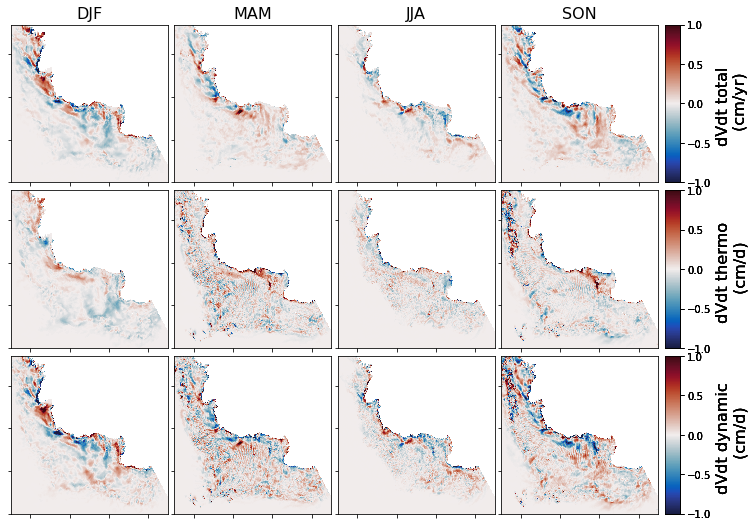

In [21]:
fig = plt.figure(figsize=(12,9))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)

for ii in range(4):
    
    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_total_seasonal_3yr[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance)
    plt.title(season[ii], fontsize=ft_size)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt total \n (cm/yr)', fontsize=ft_size)

    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_t_seasonal_3yr[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt thermo \n (cm/d)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs2[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_d_seasonal_3yr[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs2[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt dynamic \n (cm/d)', fontsize=ft_size)

### Last three years

In [22]:
cntr_3yr = cntr.sel(time=slice('2008-03-01','2011-02-28')).groupby('time.season').mean('time')
pert_3yr = pert.sel(time=slice('2008-03-01','2011-02-28')).groupby('time.season').mean('time')

In [23]:
diff_t_seasonal_3yr = pert_3yr.dvidtt - cntr_3yr.dvidtt
diff_d_seasonal_3yr = pert_3yr.dvidtd - cntr_3yr.dvidtd
diff_total_seasonal_3yr = (diff_t_seasonal_3yr + diff_d_seasonal_3yr)

/jobfs/67419030.gadi-pbs/ipykernel_73853/4234817468.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_total_seasonal_3yr[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance_r)
/jobfs/67419030.gadi-pbs/ipykernel_73853/4234817468.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_t_seasonal_3yr[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance_r)
/jobfs/67419030.gadi-pbs/ipykernel_73853/4234817468.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incre

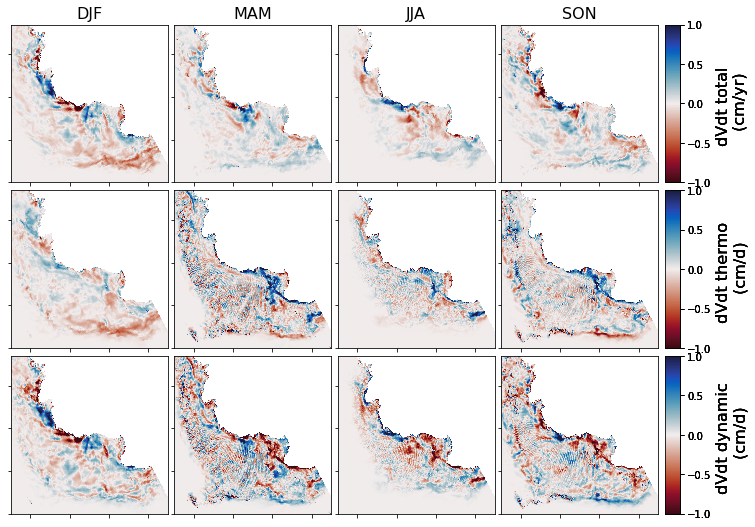

In [31]:
fig = plt.figure(figsize=(12,9))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)

for ii in range(4):
    
    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_total_seasonal_3yr[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance_r)
    plt.title(season[ii], fontsize=ft_size)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt total \n (cm/yr)', fontsize=ft_size)

    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_t_seasonal_3yr[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance_r)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt thermo \n (cm/d)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs2[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_d_seasonal_3yr[ii], vmin=-1, vmax=1, cmap=cmo.cm.balance_r)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs2[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt dynamic \n (cm/d)', fontsize=ft_size)

### Last three years, seasonal integral

In [35]:
cntr_sum = (cntr.sel(time=slice('2008-03-01','2011-02-28'))*5).groupby('time.season').sum('time')
pert_sum = (pert.sel(time=slice('2008-03-01','2011-02-28'))*5).groupby('time.season').sum('time')

In [37]:
diff_t_seasonal_sum = pert_sum.dvidtt - cntr_sum.dvidtt
diff_d_seasonal_sum = pert_sum.dvidtd - cntr_sum.dvidtd
diff_total_seasonal_sum = (diff_t_seasonal_sum + diff_d_seasonal_sum)

/jobfs/67419030.gadi-pbs/ipykernel_73853/1403933085.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_total_seasonal_sum[ii], vmin=-100, vmax=100, cmap=cmo.cm.balance_r)
/jobfs/67419030.gadi-pbs/ipykernel_73853/1403933085.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_t_seasonal_sum[ii], vmin=-100, vmax=100, cmap=cmo.cm.balance_r)
/jobfs/67419030.gadi-pbs/ipykernel_73853/1403933085.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonical

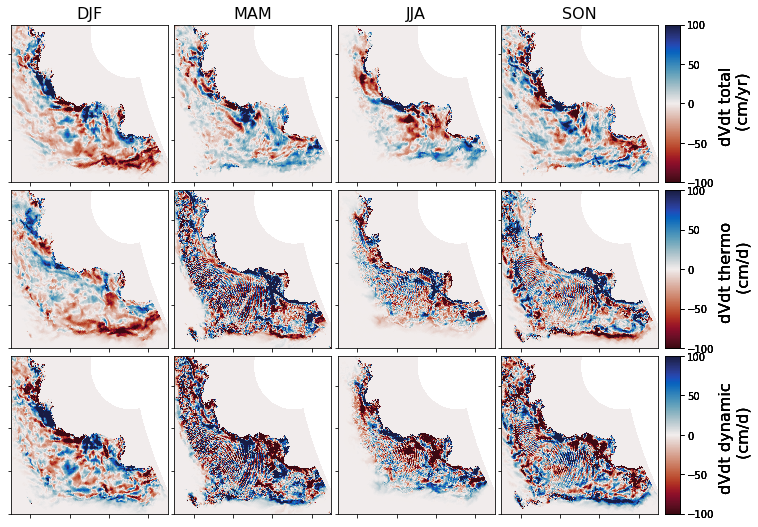

In [39]:
fig = plt.figure(figsize=(12,9))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)

for ii in range(4):
    
    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_total_seasonal_sum[ii], vmin=-100, vmax=100, cmap=cmo.cm.balance_r)
    plt.title(season[ii], fontsize=ft_size)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt total \n (cm/yr)', fontsize=ft_size)

    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_t_seasonal_sum[ii], vmin=-100, vmax=100, cmap=cmo.cm.balance_r)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt thermo \n (cm/d)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs2[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_d_seasonal_sum[ii], vmin=-100, vmax=100, cmap=cmo.cm.balance_r)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.tick_params(labelleft=False, labelbottom=False)
    cbar_ax0 = fig.add_subplot(gs2[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0)
    cbar.set_label('dVdt dynamic \n (cm/d)', fontsize=ft_size)